# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
import cv2 as cv

In [2]:
# params 

original_image_size = (720,1280,3)

# Explore the dataset

## Import the dataset

In [48]:
dir_ = "C:/Users/franc/Desktop/Aitek/Data/nexet/nexet/"
data_annotation_path = "C:/Users/franc/Desktop/Aitek/Data/nexet/nexet/train_boxes.csv"

# read the dataset
data = pd.read_csv(data_annotation_path)
data.head()

,image_filename,x0,y0,x1,y1,label,confidence
0,frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...,601.600000,270.355731,726.755556,421.185771,van,1.0
1,frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...,497.777778,308.774704,534.755556,338.656126,car,1.0
2,frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...,449.422222,310.197628,509.155556,358.577075,car,1.0
3,frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...,711.111111,304.505929,786.488889,368.537549,car,1.0
4,frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...,584.533333,307.351779,647.111111,358.577075,car,1.0


## Preprocess the dataset

### Make class IDs integers

This function changes the class attributes from strings to integers.

In [49]:
transformation_map = {'car':1, 'van':2, 'bus':3, 'truck':4, 'pickup_truck':5}

In [58]:
def class2int(data, transformation_map):
    return_array = np.zeros(len(data)).astype(int)
    for index, value in enumerate(data):
        return_array[index] = transformation_map[value]
    return return_array

def rescale_BB_coordinates(data):
    # rescale the data only if they are not already scaled
    if data['x0'][(np.random.randint(0,100))]>1: 
        # load random image in order to get the image size
        random_imge = cv.imread(os.path.join(dir_,"nexet_2017_1/",data["image_filename"][11]))
        image_H = random_imge.shape[1]
        image_W = random_imge.shape[0]
        # rescale BB coordinates according to iamge dimensions
        data['x0'] = data['x0']/image_H
        data['y0'] = data['y0']/image_W
        data['x1'] = data['x1']/image_H
        data['y1'] = data['y1']/image_W

# make classes integer
integer_classes = class2int(data['label'], transformation_map)

# rescale BB coordinates
rescale_BB_coordinates(data)

In [59]:
data['Integer_Labels'] = integer_classes

In [60]:
data.head()

,image_filename,x0,y0,x1,y1,label,confidence,Integer_Labels
0,frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...,0.470000,0.375494,0.567778,0.584980,van,1.0,2
1,frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...,0.388889,0.428854,0.417778,0.470356,car,1.0,1
2,frame_817c47b8-22c4-438a-8dc6-0e3f67f299ee_000...,0.351111,0.430830,0.397778,0.498024,car,1.0,1
3,frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...,0.555556,0.422925,0.614444,0.511858,car,1.0,1
4,frame_a9110bf2-5252-4ec6-83c6-33b65d0fc04d_000...,0.456667,0.426877,0.505556,0.498024,car,1.0,1


# Check weather the classes are evenly represented

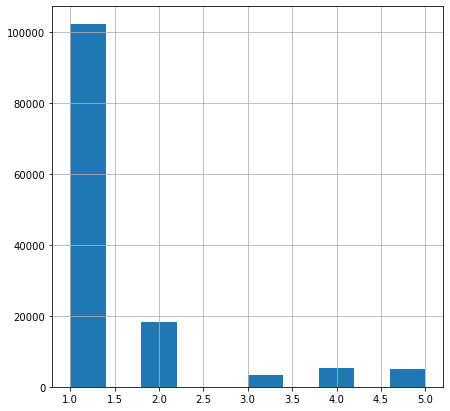

In [61]:
data['Integer_Labels'].hist(figsize=(7,7))

Unfortunately the classes are not evenly represented. We can augment under-represented classes or drop some "car" examples.

# Create a generator for loading the batches

 ## Play a bit with the images

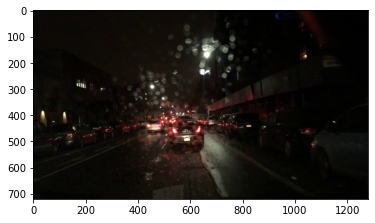

In [75]:
# Pay attention that opencv loads images in the BGR format!
test_image = cv.imread(os.path.join(dir_,"nexet_2017_1/",data["image_filename"][11]))

# cvtColor changes determins the color conversion
rgb_test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)
ground_truth_image = data.loc[11]

# plot the RGB imagw
plt.imshow(rgb_test_image)
plt.show()

In [92]:
def Draw_BB(orig_image, image_data, fontscale=2, bb_thickness=2):
    
    # copy the original image to not modify the original
    image = np.copy(orig_image)
    image_H = image.shape[1]
    image_W = image.shape[0]
    
    # unpack image data
    file, x0, y0, x1, y1, label, confidence, Integer_Labels = image_data
    
    # upper left corner of the rectangle
    start_point= (int(x0*image_H), int(y0*image_W))
    
    # lower right corner of the rectangle
    stop_point= (int(x1*image_H), int(y1*image_W))

    # draw the rectangle
    image = cv.rectangle(image, start_point, stop_point, color=(0,0,255), thickness=10)
    
    # write BB class
    text_origin = start_point
    font = cv.FONT_HERSHEY_SIMPLEX 
    fontScale=fontscale
    color=(0,255,0)
    thickness=bb_thickness
    image = cv.putText(image, label, text_origin, font,  fontScale, color, thickness, cv.LINE_AA)
    
    return image

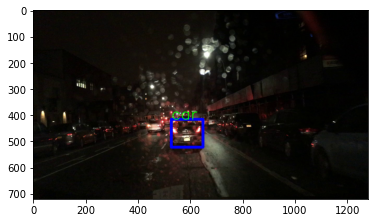

In [93]:
plt.imshow(Draw_BB(rgb_test_image, ground_truth_image))
plt.show()

## Preprocess the image

In [94]:
def Image_Preprocessing(image, final_dimensions):
    # resize the image 
    resized_image = cv.resize(image, final_dimensions)
    return resized_image

In [95]:
prep_image = Image_Preprocessing(rgb_test_image, (416,416))

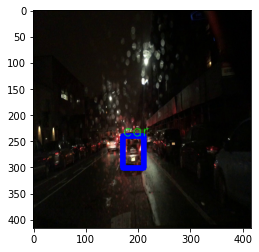

In [99]:
plt.imshow(Draw_BB(prep_image, ground_truth_image,1,1))
plt.show()

# Generator: load a batch at a time

In [ ]:
def Batch_Generator(data, batch_size, original_image_size):
    
    ''' 
        This function creates two batches, one containing the images and the other containing the boundig box parameters.
        The parameters are stored in the following order:
            1. x0, y0, x1, y1: BB upper left corner and lower right corner coordinates
            2. confidence: confidence for the prediction
            3. Integer_Labels: class labels
    '''
    
    while True:
        
        # random generate 30 indeces
        batch_IDs = np.random.randint(0, data.shape[0], size=batch_size)
        
        # initialize images batch
        images_batch = np.zeros((batch_size,original_image_size[0],original_image_size[1],original_image_size[2]))
        
        # initialize parameters batch
        BB_params_size = 6
        image_class = 1
        confidence_num = 1 
        BB_params_batch = np.zeros((batch_size,BB_params_size,confidence_num,image_class))
        
        for i in range(batch_size):
            
            # unpack image data
            file, x0, y0, x1, y1, label, confidence, Integer_Labels = data.loc[batch_IDs[i]]
            
            # read the image
            image = cv.imread(os.path.join(dir_,"nexet_2017_1/",file))
            
            # add the image to batch
            images_batch[i] = image
            
            # BB parameters batch
            BB_params_batch[i,...] = np.array([x0, y0, x1, y1, confidence, Integer_Labels]).reshape(6,1,1)
        
        yield images_batch, BB_params_batch

In [ ]:
help(Batch_Generator)

# Define the model

In [111]:
# size of the input images
input_image_size = (416,416,3)

# bounding boxes per cell
BB_per_cell = 3 

# number of classes in the dataset
Classes = 5

# Batch size
batch_ = 1

In [112]:
# Weight matrix initialization whenever using relu
relu_initializer = tf.keras.initializers.he_normal()

In [127]:
# input lauer
input_layer = tf.keras.layers.Input(shape=input_image_size, batch_size=batch_, name="input")

# down_sampling
conv_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),
             activation='relu', kernel_initializer=relu_initializer, name="conv_1")(input_layer)

pooling_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), name="pool_1")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1),
             activation='relu', kernel_initializer=relu_initializer, name="conv_2")(pooling_1)

pooling_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), name="pool_2")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
             activation='relu', kernel_initializer=relu_initializer, name="conv_3")(pooling_2)

pooling_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), name="pool_3")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=BB_per_cell*(5+Classes), kernel_size=(3,3), strides=(1,1),
             activation='relu', kernel_initializer=relu_initializer, name="conv_4")(pooling_3)

pooling_4 = tf.keras.layers.MaxPool2D(pool_size=(2,2), name="detection_1")(conv_4)

# up sampling

up_sampling_1 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest", name="up_sampling_1")(pooling_4)

concat_layer_1 = tf.keras.layers.Concatenate(name="detection_2")([conv_4,up_sampling_1])

# conv_5 = tf.keras.layers.Conv2D(filters=BB_per_cell*(5+Classes), kernel_size=(1,1), strides=(1,1),
#              activation='relu', kernel_initializer=relu_initializer, name="detection_2")(up_sampling_1)
# 
# up_sampling_2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="nearest", name="up_sampling_2")(conv_5)
# 
# conv_6 = tf.keras.layers.Conv2D(filters=BB_per_cell*(5+Classes), kernel_size=(1,1), strides=(1,1),
#              activation='relu', kernel_initializer=relu_initializer, name="detection_3")(up_sampling_2)
# 


In [128]:
model = tf.keras.Model(inputs=input_layer, outputs=[pooling_4, concat_layer_1], name="My_SSD_detector")

In [129]:
model.summary()

Model: "My_SSD_detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 416, 416, 3)]   0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (1, 414, 414, 256)   7168        input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (1, 207, 207, 256)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (1, 205, 205, 128)   295040      pool_1[0][0]                     
____________________________________________________________________________________

## Setting up the tensorboard

In [ ]:
# set up the tensorbard directory
import os 

root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir(root_logdir):
    import time
    run_dir = time.strftime("run%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_dir)

run_logdir = get_run_logdir(root_logdir)

# tensorboard callback
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)